In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: therealnightmare
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:06<00:00, 106MB/s] 


In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image  in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)
data_df = pd.DataFrame(zip(image_path,labels), columns=["image_path","labels"])

In [5]:
data_df.head()

,image_path,labels
0,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
1,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
2,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
3,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
4,/content/animal-faces/afhq/train/cat/pixabay_c...,cat


In [6]:
print(data_df["labels"].unique())

['cat' 'wild' 'dog']


In [7]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test   = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(11291, 2)
(2419, 2)
(2420, 2)


In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [9]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]

    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [10]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

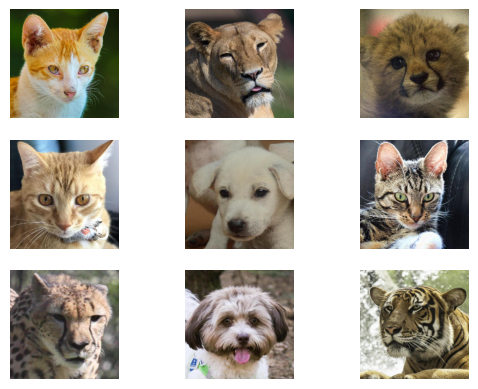

In [11]:
n_rows = 3
n_cols = 3

f, axarr, = plt.subplots(n_rows,n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n = 1)["image_path"].iloc[0]).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')
plt.show()

In [12]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32,64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16),128)

    self.output = nn.Linear(128, len(data_df["labels"].unique()))

  def forward(self, x):
    x = self.conv1(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.pooling(x)
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.output(x)
    return x

In [15]:
model = Net().to(device)

In [16]:
from torchsummary import summary
summary(model, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [19]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis=1)==labels).sum().item()

    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs,labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis=1)==labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))

  total_acc_train_plot.append(round((total_acc_train/ train_dataset.__len__())*100,4))
  total_acc_validation_plot.append(round((total_acc_val/ val_dataset.__len__())*100,4))

  print(f'''
    Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000,4)} Train Accuracy {round((total_acc_train/ train_dataset.__len__())*100,4)}
    Validation Loss {round(total_loss_val/1000,4)} Validation Accuracy {round((total_acc_val/ val_dataset.__len__())*100,4)}
  ''')


    Epoch 1/10, Train Loss: 0.1444 Train Accuracy 92.7199
    Validation Loss 0.0332 Validation Accuracy 91.3636
  

    Epoch 2/10, Train Loss: 0.0934 Train Accuracy 95.2883
    Validation Loss 0.0218 Validation Accuracy 94.8347
  

    Epoch 3/10, Train Loss: 0.0627 Train Accuracy 96.8825
    Validation Loss 0.0207 Validation Accuracy 95.6612
  

    Epoch 4/10, Train Loss: 0.0486 Train Accuracy 97.4493
    Validation Loss 0.0166 Validation Accuracy 96.1157
  

    Epoch 5/10, Train Loss: 0.0311 Train Accuracy 98.4767
    Validation Loss 0.0173 Validation Accuracy 96.5289
  

    Epoch 6/10, Train Loss: 0.0226 Train Accuracy 98.8664
    Validation Loss 0.0203 Validation Accuracy 95.9091
  

    Epoch 7/10, Train Loss: 0.0184 Train Accuracy 99.1409
    Validation Loss 0.0265 Validation Accuracy 94.9587
  

    Epoch 8/10, Train Loss: 0.0118 Train Accuracy 99.5395
    Validation Loss 0.023 Validation Accuracy 95.7025
  

    Epoch 9/10, Train Loss: 0.0107 Train Accuracy 99.504
    Val

In [20]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 96.2795 and Loss is 0.0213


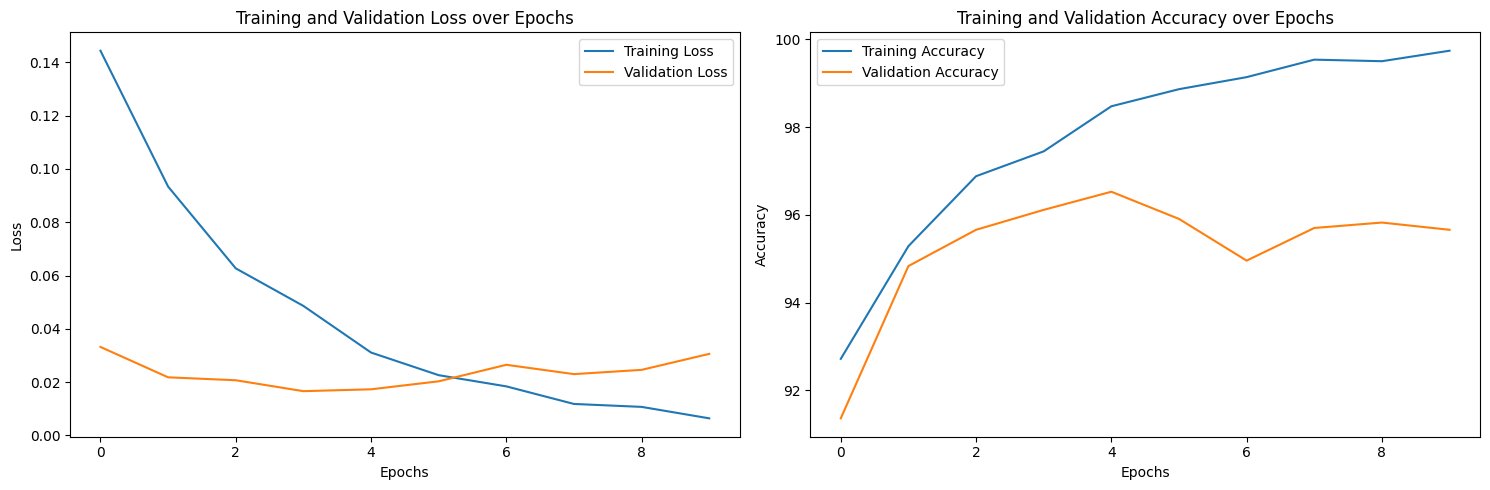

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

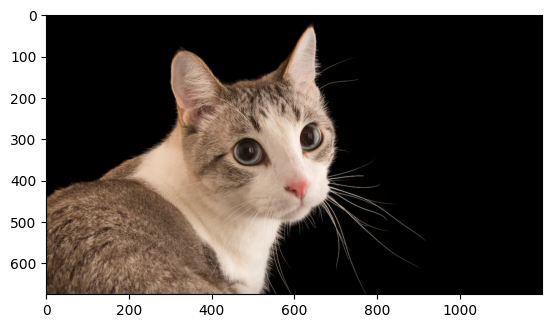


Prediction: 



array(['cat'], dtype=object)

In [25]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

image = Image.open("/content/blacky.avif")
plt.imshow(image)
plt.show()

print()
print("Prediction: \n")
predict_image("/content/blacky.avif")

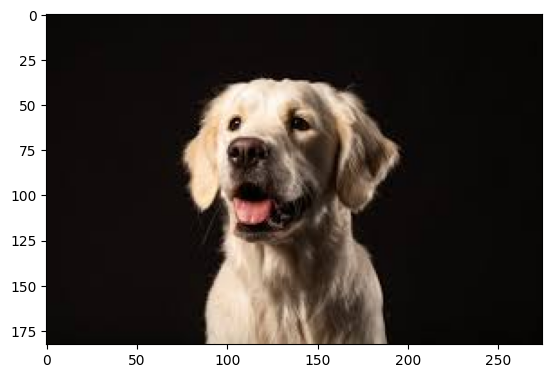


Prediction: 



array(['dog'], dtype=object)

In [26]:
image = Image.open("/content/dog.jpg")
plt.imshow(image)
plt.show()

print()
print("Prediction: \n")
predict_image("/content/dog.jpg")